In [1]:
import json
import tqdm
import numpy as np 

from os import listdir
from os.path import isfile, join
from datetime import datetime, timedelta
from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_tweet_timestamp(tid):
    offset = 1288834974657
    tstamp = (tid >> 22) + offset
    utcdttime = datetime.utcfromtimestamp(tstamp/1000)
#     print(str(tid) + " : " + str(tstamp) + " => " + str(utcdttime))
    return utcdttime

In [4]:
data_path = 'data/tweets0104'
files = [f for f in listdir(data_path) if isfile(join(data_path, f))]
ids = [int(file[:-5]) for file in files]

times_all = []
for user in tqdm.tqdm(ids):
    user_tweets = json.load(open(data_path + "/" + str(user) + ".json"))
    user_beliefs = []
    try:
        user_times = [get_tweet_timestamp(int(tweet['id'])) for tweet in user_tweets['data']]
        times_all.append(user_times)
    except:
        times_all.append([])

100%|███████████████████████████████████████| 535/535 [00:00<00:00, 8131.68it/s]


In [5]:
start = datetime.strptime("01-01-2020", "%d-%m-%Y")
end = datetime.strptime("01-04-2020", "%d-%m-%Y")
date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]

### too sparse, take every 7th day
date_generated = date_generated[::7]

In [6]:
def get_beliefs(beliefs_raw, times_raw, dates):
    prev_belief = 0.5
    beliefs = []
    for date in dates:
        idx = []
        for i, time_raw in enumerate(times_raw):
            if time_raw.date() == date.date():
                idx.append(i)
        if idx != []:
            beliefs.append(np.mean(np.array(beliefs_raw)[idx]))
            prev_belief = beliefs[-1]
        else:
            beliefs.append(prev_belief)
    return np.array(beliefs)

In [7]:
beliefs = json.load(open("data/belifs_all_dict0104.json", "r"))

beliefs_seq = []
for i, user in enumerate(ids):
    beliefs_user_raw = beliefs[str(user)]
    times_user_raw = times_all[i]
    beliefs_seq.append(get_beliefs(beliefs_user_raw, times_user_raw, date_generated))

In [8]:
ids_dct = {}
for i, user in enumerate(ids):
    ids_dct[str(user)] = i
    ids_dct[user] = i

In [9]:
# Read data from file:
matrix_dict = json.load(open("data/graph_dict.json"))

matrix_renumbered = {}
for k, v in matrix_dict.items():
    matrix_renumbered[ids_dct[k]] = [ids_dct[n] for n in v]

In [10]:
N = len(ids_dct)//2
matrix = np.zeros((N, N))
for k, v in matrix_renumbered.items():
    matrix[k][v] = 1

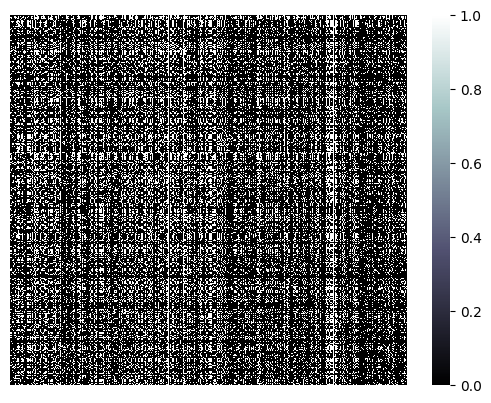

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.heatmap(matrix, yticklabels=False, xticklabels=False, cbar=True,
            cmap=sns.color_palette("bone", as_cmap=True), vmin=0, vmax=1)
plt.show()

In [12]:
norm = matrix.sum(0)[None, :]
norm[norm==0] = 1
matrix = matrix / norm

/var/folders/l6/c459dpf17p59w60nyx09r4x00000gp/T/ipykernel_9179/2556816048.py:5: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(1-matrix), yticklabels=False, xticklabels=False, cbar=True,


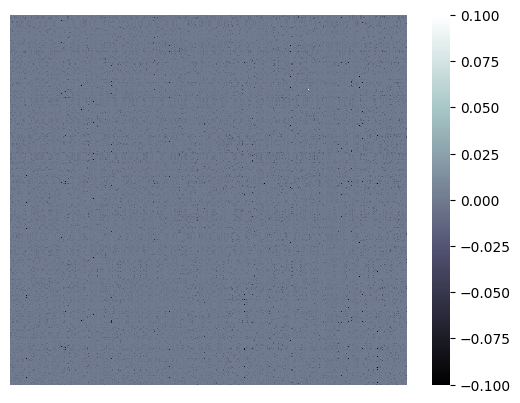

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.heatmap(np.log(1-matrix), yticklabels=False, xticklabels=False, cbar=True,
            cmap=sns.color_palette("bone", as_cmap=True))
plt.show()

In [14]:
beliefs_seq = np.array(beliefs_seq)
np.save("data/belifs_seq_dict0104.npy", beliefs_seq)
np.save("data/graph.npy", matrix)

### $\delta$ search

In [15]:
beliefs = np.load("data/belifs_seq_dict0104.npy").T
network = np.load("data/graph.npy")

In [16]:
def get_divergence(beliefs, network, delta):
    N = beliefs.shape[0]
    div = np.zeros(beliefs.shape[1])
    for i in range(1, N):
        div += beliefs[i] - (1-delta)*network.T@beliefs[i-1]
    if delta != 0:
        div = div / (N-1) / delta
    else:
        div = div / (N-1)
    return div

In [17]:
def get_error(beliefs, network, divergence, delta):
    avg = beliefs.mean(0)
    if delta == 0:
        beta = 1
    else:
        beta = delta
    return np.linalg.norm(avg - (1-delta)*network.T@avg - beta*divergence)/avg.shape[0]

In [18]:
N = beliefs.shape[0]

In [19]:
delta_range = np.linspace(0., 1., 21)
delta_range[0] = 0.01
delta_range[-1] = 0.99

delta_range = np.linspace(0.025, .975, 39)

errors = []
for delta in delta_range:
    div = get_divergence(beliefs[:N//2], network, delta)
    error = get_error(beliefs[N//2:], network, div, delta)
    errors.append(error)

In [20]:
delta_range

array([0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225,
       0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 ,
       0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675,
       0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  ,
       0.925, 0.95 , 0.975])

In [21]:
div = get_divergence(beliefs[:N//2], network, 0)
error0 = get_error(beliefs[N//2:], network, div, 0)

In [22]:
import matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

font = {'size': 14}
matplotlib.rc('font', **font)

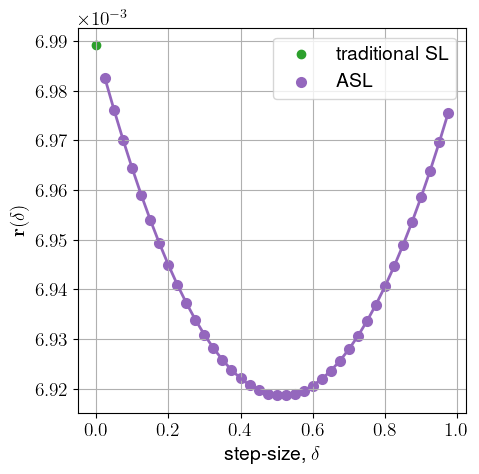

In [23]:
colors = sns.color_palette("tab10")

plt.figure(figsize=(5, 5))
plt.plot(delta_range, errors, color=colors[4], lw=2)

plt.xlabel('step-size, $\delta$')
plt.ylabel('$\mathbf{r}(\delta)$')
plt.ticklabel_format(axis='y', scilimits=[-3,3])
plt.grid()
plt.scatter(0, error0, color=colors[2], label='traditional SL')
plt.scatter(delta_range, errors, color=colors[4], lw=2, label='ASL')
# plt.show()
plt.legend()
plt.savefig('figures/brexit_delta3.png', dpi=300, bbox_inches='tight')